### Name: Qiaoqiao Zou ###

#----------------------------------Setting 2 (62.5%)------------------------------#

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV,train_test_split

os.environ["OBJC_DISABLE_INITIALIZE_FORK_SAFETY"] = "YES"

In [2]:
# Load dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(newsgroups.data)  # Features (18846 samples, 2000 features each)
y = newsgroups.target  # Labels (digits 0 to19)

In [3]:
# Convert sparse to dense for PCA
X_dense = X.toarray()

In [4]:
# Split into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.2, random_state=42, stratify=y)

Goal for Setting 2: Building a machine learning pipeline with minimum number of features achieving more than 62.5% accuracy on test dataset using topics covered in the lecture so far. DO NOT CHANGE THE CODE ABOVE.

In [5]:
# Check the shape of X_train
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (15076, 2000)
y_train shape: (15076,)


In [6]:
# Check the proportion of non-zero elements (sparseness)
nonzero_ratio = np.count_nonzero(X_train) / (X_train.shape[0] * X_train.shape[1])
print(f"Non-zero Ratio: {nonzero_ratio:.4f}") 

Non-zero Ratio: 0.0166


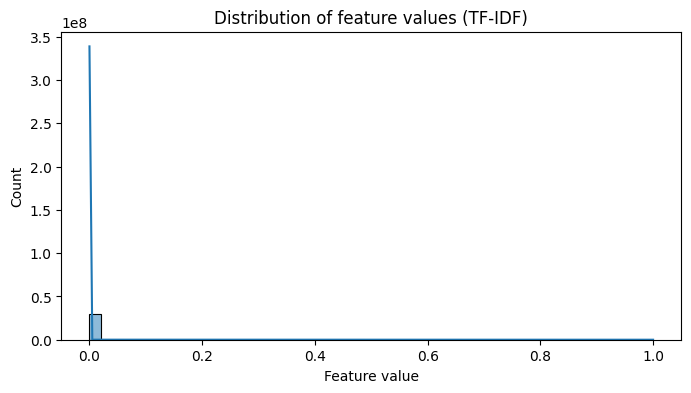

In [7]:
# View the eigenvalue distribution
plt.figure(figsize=(8,4))
sns.histplot(X_train.flatten(), bins=50, kde=True)
plt.title("Distribution of feature values (TF-IDF)")
plt.xlabel("Feature value")
plt.ylabel("Count")
plt.show()

In [8]:
# View category distribution
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

Label 0: 639 samples
Label 1: 778 samples
Label 2: 788 samples
Label 3: 786 samples
Label 4: 770 samples
Label 5: 790 samples
Label 6: 780 samples
Label 7: 792 samples
Label 8: 797 samples
Label 9: 795 samples
Label 10: 799 samples
Label 11: 793 samples
Label 12: 787 samples
Label 13: 792 samples
Label 14: 790 samples
Label 15: 798 samples
Label 16: 728 samples
Label 17: 752 samples
Label 18: 620 samples
Label 19: 502 samples


## Find the best selection and number of feartures ##

In [9]:
# Scale + PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', gamma='scale', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVM": SVC(kernel='linear', random_state=42)
}

for k in [95,96, 97,98, 99, 100]:
    print(f"\nPCA components: {k}")
    for name, clf in classifiers.items():
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=k,random_state=42)),
            ('clf', clf)
        ])
        pipe.fit(X_train, y_train)
        acc = pipe.score(X_test, y_test)
        print(f"{name:<20} Accuracy: {acc:.4f}")


PCA components: 95
Logistic Regression  Accuracy: 0.6056
SVM (RBF)            Accuracy: 0.6239
Random Forest        Accuracy: 0.5920
Linear SVM           Accuracy: 0.5958

PCA components: 96
Logistic Regression  Accuracy: 0.6090
SVM (RBF)            Accuracy: 0.6257
Random Forest        Accuracy: 0.5931
Linear SVM           Accuracy: 0.6024

PCA components: 97
Logistic Regression  Accuracy: 0.6090
SVM (RBF)            Accuracy: 0.6255
Random Forest        Accuracy: 0.6013
Linear SVM           Accuracy: 0.5920

PCA components: 98
Logistic Regression  Accuracy: 0.6082
SVM (RBF)            Accuracy: 0.6241
Random Forest        Accuracy: 0.5934
Linear SVM           Accuracy: 0.5963

PCA components: 99
Logistic Regression  Accuracy: 0.6167
SVM (RBF)            Accuracy: 0.6300
Random Forest        Accuracy: 0.5947
Linear SVM           Accuracy: 0.6061

PCA components: 100
Logistic Regression  Accuracy: 0.6048
SVM (RBF)            Accuracy: 0.6225
Random Forest        Accuracy: 0.5960
Linea


So , the least PCA dimension: n_components = 99
Classifier: SVC(kernel='rbf')
### Parameter adjustment: optimize C and gamma ###

## Find out the parameters of model ##

In [13]:
# Building the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=99)),
    ('clf', SVC(kernel='rbf'))
])

# Set the parameter search scope
param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': [0.001, 0.01, 0.1, 1]
}

# Executing GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=3, verbose=0, n_jobs=1)
grid.fit(X_train, y_train)

# Evaluate on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid.best_params_)
print(f"Test Accuracy: {acc * 100:.2f}%")

Best Parameters: {'clf__C': 1, 'clf__gamma': 0.01}
Test Accuracy: 62.94%


we still need to find the least number of feartures.

## Fine-tune the minimum features value ##

In [16]:
components_to_test = range(65, 99, 1)  # 从 65 到 99 

for k in components_to_test:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=k, random_state=42)),
        ('clf', SVC(C=1, gamma=0.01, random_state=42))
    ])
    pipe.fit(X_train, y_train)
    acc = pipe.score(X_test, y_test)
    print(f"PCA components = {k:3d} → Test Accuracy = {acc * 100:.2f}%")
    
    if acc >= 0.625:
        print(f"Found smaller PCA dimension {k} is the minimum number of features to reach 62.5%!")
        break

PCA components =  65 → Test Accuracy = 61.86%
PCA components =  66 → Test Accuracy = 62.39%
PCA components =  67 → Test Accuracy = 61.46%
PCA components =  68 → Test Accuracy = 62.25%
PCA components =  69 → Test Accuracy = 62.28%
PCA components =  70 → Test Accuracy = 62.49%
PCA components =  71 → Test Accuracy = 62.81%
Found smaller PCA dimension 71 is the minimum number of features to reach 62.5%!


##  conclusion ##

So, the minimum number of features is 71, the selection method is PCA;

and the model is RBF SVM;

The parameters are: C =1, gamma = 0.01.